In [1]:
import pandas as pd
import numpy as np
import gensim
from gensim.models import word2vec

In [2]:
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")
sample_submission = pd.read_csv("../data/sample_submission.csv")

In [3]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
train_df.location.value_counts(dropna=False,normalize=True)

NaN                          0.332720
USA                          0.013661
New York                     0.009326
United States                0.006568
London                       0.005911
                               ...   
Indiana, USA                 0.000131
Sligo and Galway, Ireland    0.000131
Rome, Italy                  0.000131
Hudson Valley, NY            0.000131
Aurora, Ontario              0.000131
Name: location, Length: 3342, dtype: float64

In [5]:
train_df.keyword.value_counts(dropna=False,normalize=True)

NaN                      0.008013
fatalities               0.005911
armageddon               0.005517
deluge                   0.005517
body%20bags              0.005386
                           ...   
forest%20fire            0.002496
epicentre                0.001576
threat                   0.001445
inundation               0.001314
radiation%20emergency    0.001182
Name: keyword, Length: 222, dtype: float64

In [6]:
train_df.target.value_counts(dropna=False,normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

## Preprocessing

In [7]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer 
import re
lem = WordNetLemmatizer()
tokenizer = TweetTokenizer()

In [8]:
def preprocess_sentence(sentence: str) -> list:
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    regex = re.compile('([^\s\w]|_)+')
    cleantext = regex.sub('', cleantext).lower()
    tokens = tokenizer.tokenize(cleantext)
    tokens_normalized = [word.lower() for word in tokens if len(word)>2 and word.lower() not in stopwords.words('english')]
    tokens_lemmatized = [lem.lemmatize(word) for word in tokens_normalized]
    return tokens_lemmatized

In [9]:
def preprocess_df(df: pd.DataFrame ) -> pd.DataFrame:
    df["tokens"] = df["text"].map(lambda x: preprocess_sentence(x))
    df["features"] = df.tokens.apply(lambda x: " ".join(x))
    return df

In [10]:
train_df = preprocess_df(train_df)

In [11]:
terms_frequency = pd.DataFrame({"word": [item for sublist in np.array(train_df.tokens).tolist() for item in sublist ]})

In [12]:
terms_frequency.value_counts().head(50)

word      
httptco       690
fire          350
like          347
amp           300
get           255
new           224
via           220
one           205
people        199
news          197
dont          191
time          175
video         174
emergency     158
disaster      155
body          150
year          148
police        140
building      140
home          138
day           136
family        132
would         131
still         129
say           129
life          126
storm         124
crash         124
california    121
back          121
look          120
burning       120
bomb          119
know          119
suicide       117
world         116
train         115
flood         113
got           112
see           112
death         112
man           111
car           111
attack        108
first         107
love          105
going         103
cant          102
nuclear       101
today         100
dtype: int64

# Text to features

## Bag of Words

In [13]:
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [14]:
#vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,3))
vectorizer = feature_extraction.text.TfidfVectorizer()

In [15]:
corpus = train_df.features.to_list()
vectorizer_fit = vectorizer.fit(corpus)
X = vectorizer_fit.transform(train_df.features.to_list()) 

In [16]:
y = train_df["target"].to_list()

In [17]:
X_train_df, X_test_df, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=0)

In [18]:
X_train = X[X_train_df.index]
X_test = X[X_test_df.index]

In [19]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train) 

RandomForestClassifier(n_estimators=1000, random_state=0)

In [20]:
y_pred = classifier.predict(X_test)

In [21]:
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85       886
           1       0.86      0.63      0.73       637

    accuracy                           0.80      1523
   macro avg       0.82      0.78      0.79      1523
weighted avg       0.81      0.80      0.80      1523

0.8023637557452397


In [22]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

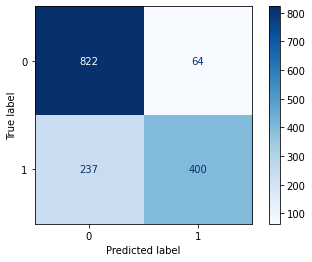

In [23]:
plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=["0", "1"],
                                 cmap=plt.cm.Blues)

In [36]:
X_test_df.loc[:,"prediction"] = y_pred

/Users/diego.garcia/.local/share/virtualenvs/kaggle-nlp-disaster-tweets-oFUYpqth/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [39]:
X_test_df[X_test_df["target"] != X_test_df["prediction"]].head(50)

,id,keyword,location,text,target,tokens,features,prediction
4970,7086,meltdown,Two Up Two Down,@LeMaireLee @danharmon People Near Meltdown Co...,0,"[lemairelee, danharmon, people, near, meltdown...",lemairelee danharmon people near meltdown comi...,1
5056,7205,natural%20disaster,USA,Coming later this year~ 'THE MAN THAT TATTOOED...,1,"[coming, later, year, man, tattooed, woman, no...",coming later year man tattooed woman novel bas...,0
1531,2213,chemical%20emergency,Ukraine and Ireland,Russian nuclear-biological-chemical (NBC) brig...,1,"[russian, nuclearbiologicalchemical, nbc, brig...",russian nuclearbiologicalchemical nbc brigade ...,0
5629,8029,refugees,NaN,Short of throwing them overboard himself I don...,1,"[short, throwing, overboard, dont, think, lead...",short throwing overboard dont think leader cou...,0
4585,6519,injuries,Carterville,Carterville High School coaches prepare for ga...,1,"[carterville, high, school, coach, prepare, ga...",carterville high school coach prepare gameday ...,0
5789,8259,rioting,trapped in America,@evacide The Ferguson RIOTS worked. This of th...,1,"[evacide, ferguson, riot, worked, next, time, ...",evacide ferguson riot worked next time say rio...,0
224,318,annihilated,NaN,@violentfeminazi I guess that's ok for Armenia...,1,"[violentfeminazi, guess, thats, armenian, sinc...",violentfeminazi guess thats armenian since wev...,0
6707,9607,thunder,gamertag: bexrayandvav,@HaydnExists so glad i saved them all at once ...,1,"[haydnexists, glad, saved, didnûªt, want, stea...",haydnexists glad saved didnûªt want stealing t...,0
2030,2913,danger,"Loughborough, England",What is this? Like I could be in danger or som...,1,"[like, could, danger, something]",like could danger something,0
2621,3761,destruction,Moscow,Truck Driver Salvages Banned Tomatoes From Des...,0,"[truck, driver, salvage, banned, tomato, destr...",truck driver salvage banned tomato destruction...,1


# Prediction

In [26]:
test_df = preprocess_df(test_df)

In [27]:
X_test = vectorizer_fit.transform(test_df.features.to_list()) 
y_test = classifier.predict(X_test)
#test_df['target'] = 

In [28]:
y_test

array([1, 1, 1, ..., 1, 1, 0])

In [29]:
test_df["target"] = y_test

# Submission

In [30]:
sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [31]:
submission = test_df[["id","target"]]

In [32]:
#submission.to_csv("submission.csv",index=False)

In [33]:
#!kaggle competitions submit -f notebooks/submission.csv -m "BoW and TIDF" nlp-getting-started

In [34]:
#!kaggle competitions submissions nlp-getting-started